In [39]:
import os
import h5py
import numpy as np
from scipy.signal import decimate
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import torch
import torch.nn as nn

In [120]:
VERBOSE = 0  # constant for debugging, higher number means more printing
TRAIN_VAL_SPLIT = 6  # number of train files per task, the rest for validation
DOWNSAMPLING_FACTOR = 10

In [18]:
def log(message: tuple, verbose_true: int, verbose_min):
    """Helper print function, based on verbose params."""
    if verbose_true >= verbose_min:
        for entry in message:
            print(entry, end=' ')
        print()

In [19]:
def load_data(filename):
    """Load data from .h5 file."""
    with h5py.File(filename, 'r') as f:
        data = f[next(iter(f.keys()))][()]
    return data

In [20]:
def data_loader(input_dir: str) -> tuple[np.ndarray, str]:
    """Generator for loading data and its filename from all .h5 files in a directory."""
    for file in os.listdir(input_dir):
        if not file.endswith('.h5'):
            continue
        path = os.path.join(input_dir, file)
        data = load_data(path)
        yield data, file

In [21]:
def create_data_file(data, output_dir, filename: str):
    """Create .h5 file with given data."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    with h5py.File(output_path, 'w') as f:
        f.create_dataset(filename.rsplit('.', 1)[0], data=data)

In [22]:
def get_file_info(filename: str) -> tuple[str, int]:
    filename = filename.rsplit('.', 1)[0].split('_')
    task, _, window = filename[-3], filename[-2], filename[-1]
    return task, int(window)

### Preprocessing

In [23]:
def downsample(data, factor):
    """Downsample data based on factor."""
    return decimate(data, factor, axis=1)

In [24]:
def get_means(data) -> np.ndarray:
    """Get means for every sensor dimension."""
    return np.mean(data, axis=1, keepdims=True)

In [25]:
def get_stds(data) -> np.ndarray:
    """Get standard deviations for every sensor dimension."""
    return np.std(data, axis=1, keepdims=True)

In [26]:
def z_score_normalize(data, means, stds):
    """Z-score normalization for every sensor dimension."""
    return (data - means) / stds

In [27]:
def downsample_and_save(input_dir, output_dir, factor, verbose):
    """Downsample data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = downsample(data, factor)
        create_data_file(data, output_dir, f"ds_{file}")

In [28]:
def normalize_and_save(input_dir, output_dir, means, stds, verbose):
    """Normalize data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = z_score_normalize(data, means, stds)
        create_data_file(data, output_dir, f"norm_{file}")

In [29]:
def concat_together(input_dir):
    """
    Concatenate data from files into a single time window of sensor readings.
    Also split to a train and validation sets.
    """
    train_data = None
    val_data = None
    for data, file in data_loader(input_dir):
        _, window = get_file_info(file)
        if window <= TRAIN_VAL_SPLIT and train_data is None:
            train_data = data
        elif window <= TRAIN_VAL_SPLIT:
            train_data = np.concat((train_data, data), axis=1)
        elif val_data is None:
            val_data = data
        else:
            val_data = np.concat((train_data, data), axis=1)
    return train_data, val_data

In [30]:
downsample_and_save('Intra/train', 'Intra/train_ds', DOWNSAMPLING_FACTOR, VERBOSE)

In [31]:
data_train, _ = concat_together('Intra/train_ds')
means, stds = get_means(data_train), get_stds(data_train)

In [32]:
normalize_and_save('Intra/train_ds', 'Intra/train_ds_norm', means, stds, VERBOSE)

### Training

In [121]:
def concat_as_samples(input_dir):
    """
    Concatenate data from files, treating each data file as a window sample
    of sensor readings. Also split them to train and validation sets.
    """
    samples_train = []
    tasks_train = []
    samples_val = []
    tasks_val = []
    for data, file in data_loader(input_dir):
        task, window = get_file_info(file)
        if window <= TRAIN_VAL_SPLIT:
            samples_train.append(data)
            tasks_train.append(task)
        else:
            samples_val.append(data)
            tasks_val.append(task)
    return np.stack(samples_train), tasks_train, np.stack(samples_val), tasks_val

In [122]:
data_train, labels_train, data_val, labels_val = concat_as_samples('Intra/train_ds_norm')
print(np.shape(data_train))
print(np.shape(data_val))
print(labels_train)

(24, 248, 3563)
(8, 248, 3563)
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']


#### Multiclass Logistic Regression

In [123]:
# Flatten the data: (24, 248, 3563) → (24, 248*3563)
X_train = data_train.reshape(len(data_train), -1)
X_val = data_val.reshape(len(data_val), -1)
print(np.shape(X_train))

# Encode string labels to integers
le = LabelEncoder()
y_train = le.fit_transform(labels_train)
y_val = le.transform(labels_val)
print(y_train)
print(y_val)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

(24, 883624)
[3 3 3 3 3 3 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1]
[3 3 2 2 0 0 1 1]


In [124]:
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # No softmax here; CrossEntropyLoss does it

In [125]:
input_dim = X_train.shape[1]
num_classes = len(set(y_train))
model = MulticlassLogisticRegression(input_dim, num_classes)

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [127]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/3, Loss: 1.4765
Epoch 2/3, Loss: 0.0000
Epoch 3/3, Loss: 0.0000


In [128]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    print(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    print('True classes     :', y_val_tensor)
    print('Model predictions:', val_predictions)
    accuracy = (val_predictions == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')

tensor([[-31201.5625, -26178.2539, -36457.7617,  39712.9375],
        [-34414.7695, -28139.9688, -41458.0273,  43984.7148],
        [  2813.7087,   2474.6396,  15035.4111, -10688.0693],
        [  2989.0618,   3457.8999,  15352.7422, -11183.6865],
        [ 12427.3057,   3997.9697,   5034.6606,  -8931.1924],
        [ 12474.6064,   4788.8110,   4968.1978,  -9153.0957],
        [  2940.0708,   9670.8418,  -1186.7765,  -3924.7671],
        [  2563.5288,   8693.1846,  -1286.2754,  -3396.7075]])
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])
Validation Accuracy: 1.0000


#### Logistic Regression with data dimensionality reduction

In [135]:
# Reshape: (samples, 248, 3563) → (samples, 248 * 3563)
X_train_flat = data_train.reshape(data_train.shape[0], -1)
X_val_flat = data_val.reshape(data_val.shape[0], -1)
print(np.shape(X_train_flat))

(24, 883624)


In [136]:
from sklearn.decomposition import PCA

# Reduce to 100 components (tune as needed)
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Convert to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)

In [138]:
input_dim = X_train_pca.shape[1]
num_classes = len(set(y_train))
model = MulticlassLogisticRegression(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    print(val_outputs)
    _, val_predictions = torch.max(val_outputs, 1)
    print('True classes     :', y_val_tensor)
    print('Model predictions:', val_predictions)
    accuracy = (val_predictions == y_val_tensor).float().mean()
    print(f'Validation Accuracy: {accuracy.item():.4f}')

Epoch 10/30, Loss: 91.0871
Epoch 20/30, Loss: 5.4303
Epoch 30/30, Loss: 0.0000
tensor([[ -73.7545, -149.6743,  169.9396,  514.3483],
        [ -68.8179, -160.6011,  188.9501,  569.1395],
        [-212.0851, -266.9196,    9.7095, -249.0159],
        [-206.0082, -272.0746,   -1.3830, -297.3456],
        [ 231.7663,   56.9210,   64.5163,   12.2731],
        [ 232.0108,   89.4946,   51.9372,   24.6367],
        [ -55.7072,  114.8162, -156.6940, -147.1962],
        [ -54.5737,  120.1084, -174.0690, -126.5344]])
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])
Validation Accuracy: 1.0000


### t-SNE data visualization

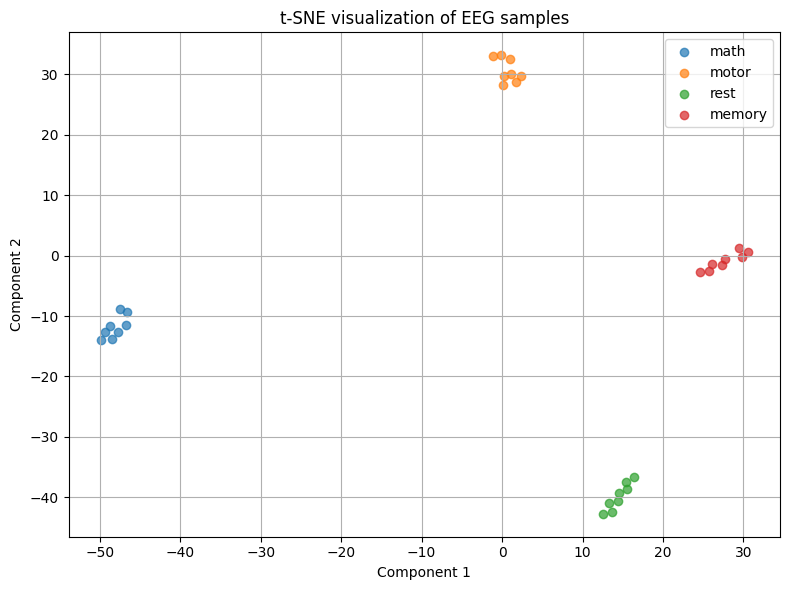

In [141]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine train and val for visualization
X_combined = np.vstack([X_train_flat, X_val_flat])
labels_combined = labels_train + labels_val

# Optional: PCA first for speed
X_combined_pca = PCA(n_components=10).fit_transform(X_combined)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_combined_pca)

# Plot
plt.figure(figsize=(8, 6))
for label in set(labels_combined):
    idx = [i for i, l in enumerate(labels_combined) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.7)
plt.legend()
plt.title("t-SNE visualization of EEG samples")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()